# Multiple-Input Single-Output Energy Teleportation
https://doi.org/10.48550/arXiv.2408.07997

A C -> B

### Import Packages

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator

## Model

### Create circuit

In [273]:
def parameters(h,k,a,c):

    K = np.sqrt(h**2+h*k+k**2)
    M1 = (8*h**3*k-4*h**2*k**2+8*h**2*k*K+5*h*k**3-8*a*k**2*K-6*k**4+6*k**3*K)/(32*h**4+32*h**3*K+18*h**2*k**2-16*h**2*k*K-11*h*k**3+14*a*k**2*K+6*k**4-6*k**3*K)
    M2 = (32*h**5*k-16*h**4*k**2+32*h**4*k*K+30*h**3*k**3-32*h**3*k**2*K-26*h**2*k**4+34*h**2*k**3*K+19*h*k**5-25*h*k**4*K-12*k**6+12*k**5*K)/(128*h**6+128*h**5*K+112*h**4*k**2-64*h**4*k*K-68*h**3*k**3+96*h**3*k**2*K+54*h**2*k**4-68*h**2*k**3*K-31*h*k**5+37*h*k**4*K+12*k**6-12*k**5*K)
    M3 = (128*h**6*k-64*h**5*k**2+128*h**5*k*K+144*h**4*k**3-128*h**4*k**2*K-128*h**3*k**4+160*h**3*k**3*K+106*h**2*k**5-136*h**2*k**4*K-69*h*k**6+87*h*k**5*K+36*k**7-36*k**6*K)/(512*h**7+512*h**6*K+544*h**5*k**2-256*h**5*k*K-320*h**4*k**3+480*h**4*k**2*K+306*h**3*k**4-368*h**3*k**3*K-202*h**2*k**5+250*h**2*k**4*K+105*h*k**6-123*h*k**5*K-36*k**7+36*k**6*K)

    x = a*(3*(h-k)*6*K)*(M1**2-M2**2-M3**2+1)/(M1**2+M2**2+M3**2+1) + (5*h**2+2*h*k+4*h*K+5*k**2-4*c*K)

    c_H = (5*h**2+2*h*k+5*k**2+4*(h-k)*np.sqrt(h**2+h*k+k**2)+2*k**2-x)/(3*(2*np.sqrt(h**2+h*k+k**2)+h-k))
    c_V = x/(3*(2*np.sqrt(h**2+h*k+k**2)+h-k))

    xi = 0.5*c*M1+0.5*c*M2-0.5*c*M3-0.5*c+K+0.5*M1*(c*M2-c*M3+c-M1*(c-2*K))+0.5*M2*(c*M1-c*M3+c-M2*(c-2*K))-0.5*M3*(c*M1+c*M2+c-M3*(4*a-c+2*K))
    eta = a*M2+c*M3-c+M1*(-a*M3+c*M1+c*M2)+M2*(a+c*M1+c*M2)-M3*(a*M1+c*M3-c)

    phi = -np.arctan2(eta/np.sqrt(xi**2+eta**2), xi/np.sqrt(xi**2+eta**2))
    return [phi, x]

def qet(h,k,a,c):

    qc = QuantumCircuit(3)
    
    # Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))/2

    qc.x(0)
    qc.ry(theta,0)
    qc.cx(0,1)
    qc.cx(0,2)
    qc.x(0)
    qc.ry(theta,1)
    qc.cx(1,2)
    qc.barrier()

    # Projective Measurements
    qc.h(0)
    qc.h(1)
    qc.barrier()

    # Bob's conditional operation A and C
    phi = parameters(h,k,a,c)[0]

    qc.cry(-phi,0,2)

    qc.x(0)
    qc.cry(phi,0,2)
    qc.x(0)

    # Bob's conditional operation B and C
    qc.cry(-phi,1,2)

    qc.x(1)
    qc.cry(phi,1,2)
    qc.x(1)

    return qc

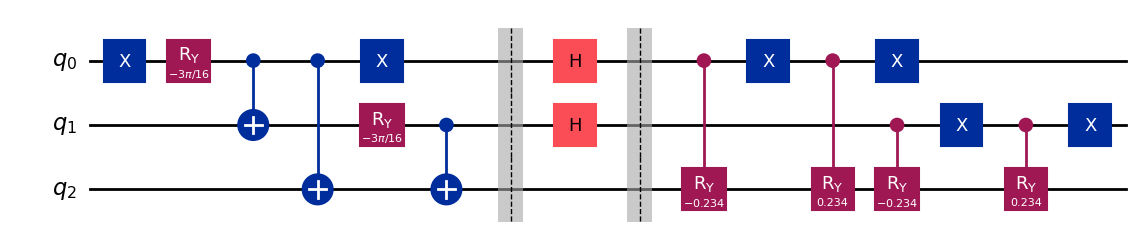

In [274]:
# Show circuit
qet(1, 1, 1, 1).draw('mpl')

In [275]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 1; k = 4; a = 0.1; c = 0.1
n_shots = 100000

# Generate circuit
qc = qet(h, k, a, c)
qc.measure_all()
qc_H = transpile(qc, simulator, optimization_level=3)

qc = qet(h,k,a,c)
qc.h(2)
qc.measure_all()
qc_V = transpile(qc,simulator, optimization_level=3)

# Run job with Sampler
sim_H = simulator.run([qc_H], shots=n_shots)
sim_V = simulator.run([qc_V], shots=n_shots)

A =  -0.9846603497358656
B =  -0.9852603497358655
C =  -0.08180034973586554


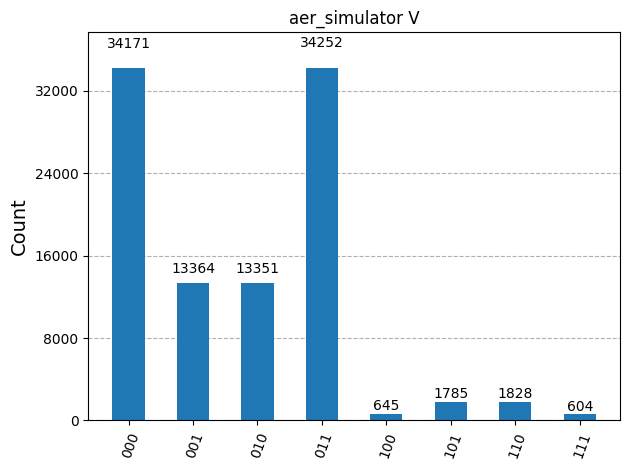

In [276]:
result = sim_H.result()
counts = result.get_counts()

x = parameters(h,k,a,c)[1]
c_H = (5*h**2+2*h*k+5*k**2+4*(h-k)*np.sqrt(h**2+h*k+k**2)+2*k**2-x)/(3*(2*np.sqrt(h**2+h*k+k**2)+h-k))

ene_A = c_H
ene_B = c_H
ene_C = c_H

error_A = []
error_B = []
error_C = []
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_B += h*(-1)**int(bit_string[1])*count/n_shots
        ene_C += h*(-1)**int(bit_string[2])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))
            error_C.append(h*(-1)**int(bit_string[2]))

print("A = ",ene_A)
print("B = ",ene_B)
print("C = ",ene_C)

plot_histogram(counts, title='aer_simulator V')


V_01 =  6.346565677382752
V_12 =  6.272325677382754
V_02 =  4.712485677382753


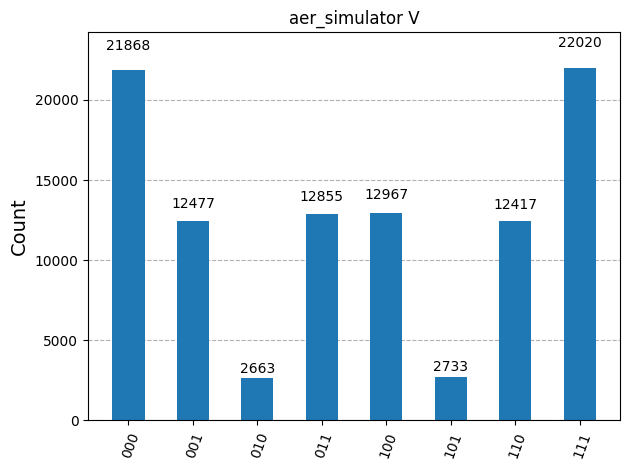

In [277]:
result = sim_V.result()
counts = result.get_counts()

x = parameters(h,k,a,c)[1]
c_V = x/(3*(2*np.sqrt(h**2+h*k+k**2)+h-k))

V_01 = c_V
V_12 = c_V
V_02 = c_V

error_V = []
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        V_01 += k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots
        V_12 += k*(-1)**int(bit_string[1])*(-1)**int(bit_string[2])*count/n_shots
        V_02 += k*(-1)**int(bit_string[0])*(-1)**int(bit_string[2])*count/n_shots

print("V_01 = ",V_01)
print("V_12 = ",V_12)
print("V_02 = ",V_02)

plot_histogram(counts, title='aer_simulator V')

In [278]:
print('E_A =', ene_A + V_01 + V_12)
print('E_C =', ene_C + V_12 + V_02)
print('V_B =', V_01 + V_12)
print('V_C =', V_02 + V_12)

E_A = 11.63423100502964
E_C = 10.90301100502964
V_B = 12.618891354765505
V_C = 10.984811354765506
